In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ktransit
from ktransit import FitTransit, LCModel

%matplotlib inline

In [3]:
time, flux = np.genfromtxt('lc.txt').T

In [4]:
time0 = time[0]

fitT = FitTransit()

fitT.add_guess_star(
    rho = 1.606, 
    ld1 = 0.627716437951, 
    ld2 = 0.454717504099,
    zpt=0.0)

fitT.add_guess_planet(
    period=2.35322,
    impact=0.3,
    T0=2457773.3170-time0,
    rprs=0.0168,)

fitT.add_guess_planet(
    period=3.560130617,
    impact=0.3,
    T0=2457740.32-time0,
    rprs=0.0262725683,)

fitT.add_guess_planet(
    period=5.405518809,
    impact=0.3,
    T0=2457743.155-time0,
    rprs=0.0277950331,)

fitT.add_guess_planet(
    period=8.26189452,
    impact=0.4,
    T0=2457740.644-time0,
    rprs=0.0353628652,)

fitT.add_guess_planet(
    period=12.758809,
    impact=0.5,
    T0=2457738.699-time0,
    rprs=0.038595707,)


fitT.add_data(
    time=time-time0,
    flux=flux-1.0,
    itime=np.ones_like(time) * 0.0188
)

In [5]:
vary_star = ['rho', 'zpt']
vary_planet = ['period', 'impact', 'rprs', 'T0']

fitT.free_parameters(vary_star, vary_planet)

In [6]:
fitT.do_fit()

In [7]:
fitT.print_results()

Best-fitting stellar parameters
zpt: 4.46901889924e-05
rho: 2.6892901214

Best-fitting planet parameters for planet 0
impact: -0.0575837997427
period: 2.3532849322
T0: 34.9406907649
rprs: 0.0159116521779

Best-fitting planet parameters for planet 1
impact: -0.00602596835251
period: 3.56001014922
T0: 1.94460549271
rprs: 0.0218102372061

Best-fitting planet parameters for planet 2
impact: -0.00751906045614
period: 5.40519748687
T0: 4.77799657784
rprs: 0.0235977722193

Best-fitting planet parameters for planet 3
impact: 0.160722203334
period: 8.26132218485
T0: 2.27008936791
rprs: 0.0304273259988

Best-fitting planet parameters for planet 4
impact: 0.489885832789
period: 12.7571958742
T0: 0.327931297737
rprs: 0.0246638444919



In [8]:
np.max(fitT.transitmodel)- np.min(fitT.transitmodel)

0.0012796786167357244

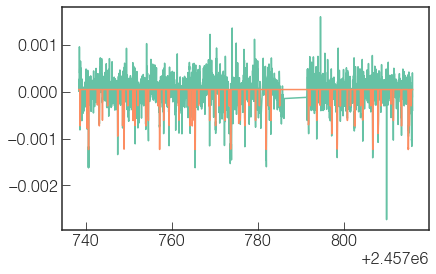

In [9]:
plt.plot(time,flux-1.0)
plt.plot(time,fitT.transitmodel)

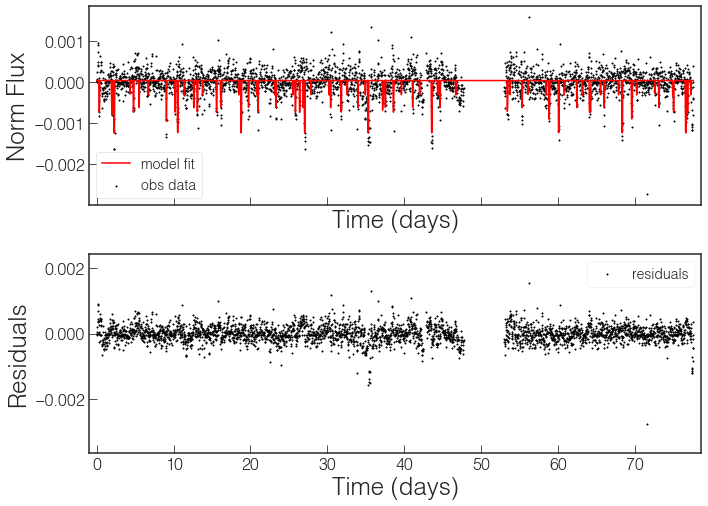

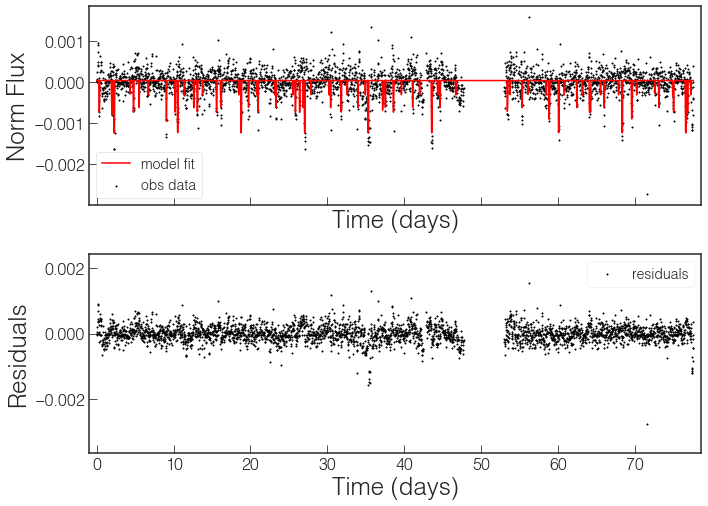

In [10]:
ktransit.plot_results(time-time0,flux-1.0,fitT.transitmodel)

In [11]:
def get_qf(time,flux,epoch,period,transitmodel=None):
    date1 = (time - epoch) + 0.5*period
    phi1 = (((date1 / period) - np.floor(date1/period)) * period) - 0.5*period
    q1 = np.sort(phi1)
    f1 = (flux[np.argsort(phi1)]) * -1.E6
    if transitmodel is not None:
        m1 = (transitmodel[np.argsort(phi1)]) * -1.E6
        return q1,f1,m1
    else:
        return q1,f1

def plot_model(ax,time,flux, rho, zpt, ld1, ld2, fitresultsplanet, cadence='long'):

    T0=fitresultsplanet['T0']
    period=fitresultsplanet['period']
    q1, f1 = get_qf(time,flux,T0,period)

    model = model_ktransit(time, rho, zpt, ld1, ld2, fitresultsplanet, cadence=cadence)
    q1, m1 = get_qf(time,model,T0,period)
    ax.scatter(q1*24., f1/10000,color='k',alpha=period**0.5/5,s=4
              )
    ax.plot(q1*24., m1/10000,color='r')
    bq, bf, be = bin_data(q1,f1,bins=50.//period)
    ax.errorbar(bq*24., bf/10000, yerr=be/10000, ls='',color='b')
    ax.set_xlim([-4,4])
    ax.set_ylim([1.19,-0.75])
    #ax.set_xlabel('Time from mid-transit (days)')
    ax.set_ylabel('Transit depth (%)', fontsize=17)
    ax.minorticks_on()
    return ax

def bin_data(phi,flux,bins,model=None):
    phi = np.array(phi)
    flux = np.array(flux)
    phibin = []
    fluxbin = []
    stdbin = []
    bins=int(bins)
    for i in (bins*np.arange(len(phi)//bins))+(bins//2):
        if model == None:
            goodpoints = np.ones(len(flux),dtype=bool)
        else:
            goodpoints = flux-model < 3* np.std(flux-model)
        flux2 = flux[goodpoints]
        phi2 = phi[goodpoints]
        phibin.append(np.median(phi2[i-bins//2:i+bins//2]))
        fluxbin.append(np.median(flux2[i-bins//2:i+bins//2]))
        stdbin.append(np.std(flux2[i-bins//2:i+bins//2]))
    return np.array(phibin), np.array(fluxbin), np.array(stdbin) / np.sqrt(bins)

def model_ktransit(time, rho, zpt, ld1, ld2, fitresultsplanet, cadence):
    M = LCModel()
    M.add_star(rho=rho,zpt=zpt,ld1=ld1,
            ld2=ld2,dil=0)
    M.add_planet(T0=fitresultsplanet['T0'],
                 period=fitresultsplanet['period'],
                 impact=fitresultsplanet['impact'],
                 rprs=fitresultsplanet['rprs']
                 )
    if cadence == 'long':
        M.add_data(time=time, itime=np.ones_like(time) * 0.0188)
    elif cadence == 'short':
        M.add_data(time=time, itime=np.ones_like(time) * 0.0188 / 30)
    return M.transitmodel

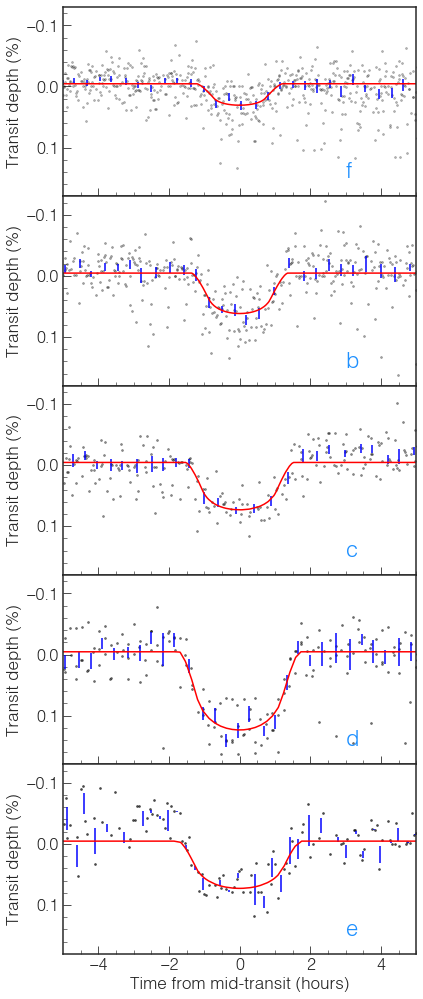

In [16]:
fig, axes = plt.subplots(5,1,figsize=[6,14], )

labels = ['f', 'b', 'c', 'd', 'e']
for i, p in enumerate(['pnum0', 'pnum1', 'pnum2', 'pnum3', 'pnum4']):
    axes[i] = plot_model(
        axes[i], time-time0, flux-1.0, 
        fitT.fitresultstellar['rho'],
        fitT.fitresultstellar['zpt'],
        0.627716437951, 
        0.454717504099,
        fitT.fitresultplanets[p],
                        )
    
    axes[i].set_ylim(0.18,-0.13)
    axes[i].set_xlim(-5,5)
    axes[i].text(3.0,0.15, labels[i], fontsize=22, color='dodgerblue')
    axes[i].tick_params(labelbottom=False, )
    axes[i].tick_params(direction='in', which='both')
axes[-1].tick_params(labelbottom=True)
axes[-1].set_xlabel('Time from mid-transit (hours)', fontsize=17)
fig.subplots_adjust(hspace=0)
plt.tight_layout(h_pad=0)

# fig.savefig('EE1-transits.png', dpi=200)

In [18]:

for i, p in enumerate(['pnum0', 'pnum1', 'pnum2', 'pnum3', 'pnum4']):
    print('{} = {:.2f} Re'.format(labels[i], fitT.fitresultplanets[p]['rprs'] * 0.807 / 0.009155))

f = 1.40 Re
b = 1.92 Re
c = 2.08 Re
d = 2.68 Re
e = 2.17 Re


In [14]:
def get_ar(rho,period):
   """ gets a/R* from period and mean stellar density"""
   G = 6.67E-11
   rho_SI = rho * 1000.
   tpi = 3. * np.pi
   period_s = period * 86400.
   part1 = period_s**2 * G * rho_SI
   ar = (part1 / tpi)**(1./3.)
   return ar

In [15]:
for i, p in enumerate(['pnum0', 'pnum1', 'pnum2', 'pnum3']):
    per =  fitT.fitresultplanets[p]['period']
    ar = get_ar(fitT.fitresultstellar['rho'], per)
    print('{} = {:.3f} AU'.format(labels[i],ar * 0.807 * 0.00464913034))

EE-1b = 0.045 AU
EE-1c = 0.059 AU
EE-1d = 0.079 AU
EE-1e = 0.105 AU


In [16]:
from blssearch import doSearch, plotSearch

minPeriod = 6
maxPeriod= 40

# outs = doSearch(time-time0,flux- 1.0- fitT.transitmodel, minPeriod, maxPeriod, )
outs = doSearch(time[fitT.transitmodel > 0]-time0, flux[fitT.transitmodel > 0]-1.0, minPeriod, maxPeriod, )

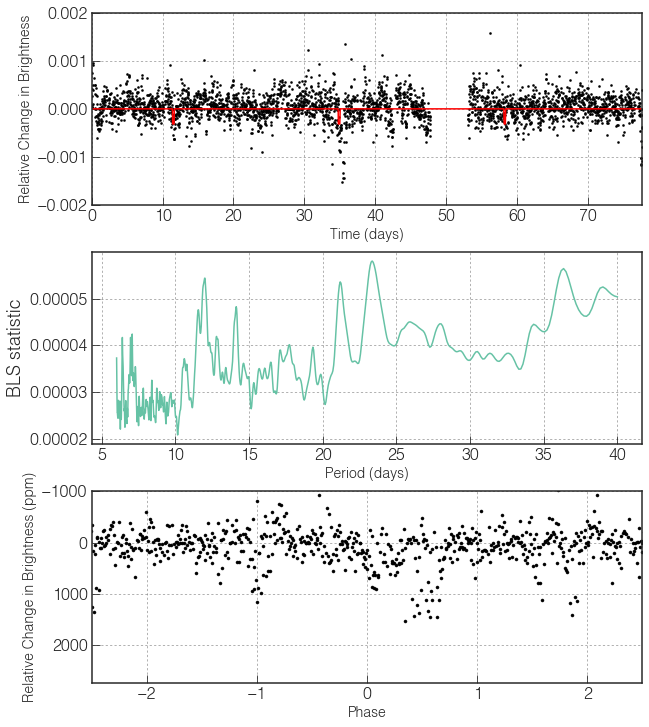

In [17]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=[9,12])
ax1.scatter(time[fitT.transitmodel > 0]-time0,flux[fitT.transitmodel > 0]-1.0, color='k',s=4)
ax1.plot(time[fitT.transitmodel > 0]-time0, outs['transitModel'] , color='r') 
# ax1.plot(timet[fitT.transitmodel > 0], outs['transitModel'] , color='r') 
ax1.set_ylim([-0.002,0.002])
ax1.set_xlim(np.min(time-time0), np.max(time-time0))
ax1.set_xlabel('Time (days)', fontsize=14)
ax1.set_ylabel('Relative Change in Brightness', fontsize=14)
ax1.grid()
ax2.grid()
ax3.grid()

#ax2.plot(time, flux ) 
ax2.plot(outs['period_guesses'], outs['convolved_bls'])
ax2.set_xlabel('Period (days)', fontsize=14)
ax2.set_ylabel('BLS statistic', fontsize=18)
# q,f = get_qf(timet[fitT.transitmodel > 0], fluxt[fitT.transitmodel > 0], outs['epoch'], outs['period'])
q,f = get_qf(time-time0, flux-1.0, outs['epoch'], outs['period'])
ax3.scatter(q,f, s=9, c='k')
ax3.set_ylim([np.max(f),-1000])
#ax3.set_xlim([np.max(q),np.min(q)])
ax3.set_xlim([-2.5,2.5])
ax3.set_xlabel('Phase', fontsize=14)
ax3.set_ylabel('Relative Change in Brightness (ppm)', fontsize=14)


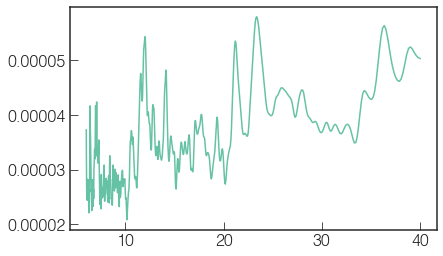

In [18]:
plt.plot(outs['period_guesses'], outs['convolved_bls'])

In [19]:
outs['epoch'], outs['period']

(34.877127173144387, 23.348835865707393)

In [20]:
plt.plfitT.transitmodel[fitT.transitmodel>0]

AttributeError: 'module' object has no attribute 'plfitT'

In [21]:
print(fitT.fitresultplanets['pnum3'])
print(np.round(np.array([fitT.fitresultplanets['pnum3'][x] for x in fitT.fitresultplanets['pnum2'].keys()]),5))

{'impact': 0.51725442263912136, 'period': 12.757172861503683, 'T0': 0.32792200849786474, 'rprs': 0.024679976459007699}
[  0.51725  12.75717   0.32792   0.02468]


In [22]:
1.9445967306443288+time0

2457740.3214037307

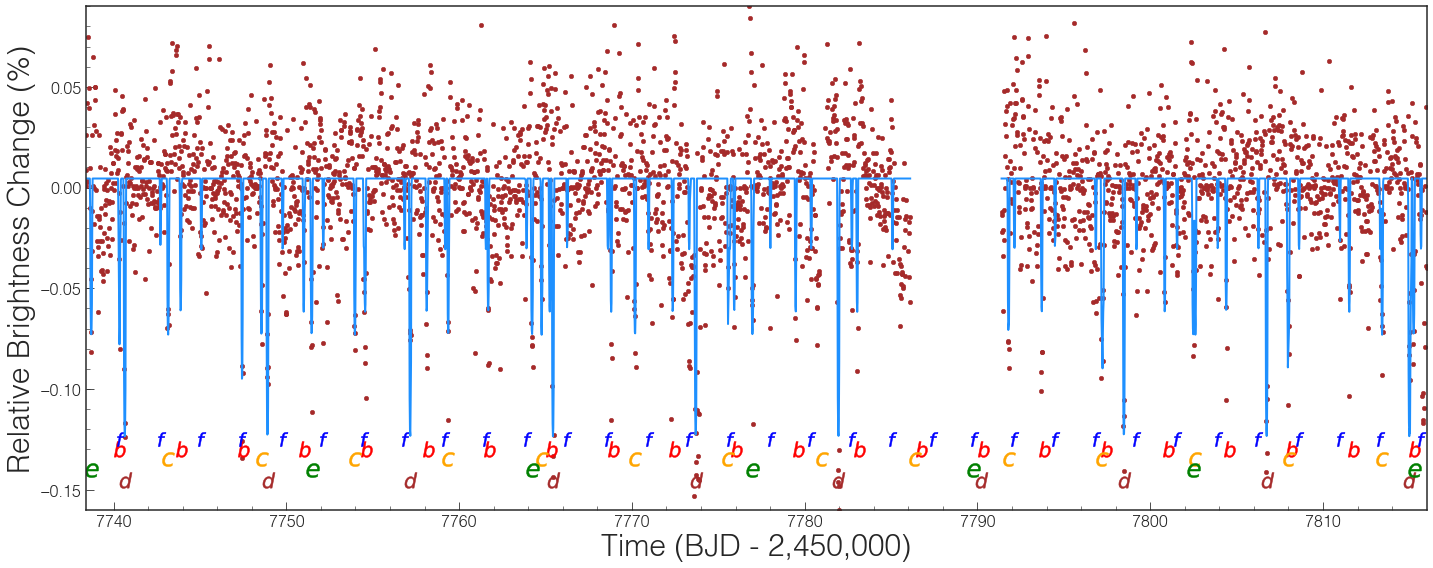

In [27]:
fig, ax2 = plt.subplots(1, 1, figsize=[20,8])
t1 = time-time0

t2 = time - 2450000

ax2.scatter(t2,100*(flux-1.0), color='brown',s=20)
ax2.plot(t2[t1<50], 100*(fitT.transitmodel[t1<50] ), color='dodgerblue', lw=2)
ax2.plot(t2[t1>50], 100*(fitT.transitmodel[t1>50] ), color='dodgerblue', lw=2)

p1 = np.arange(1.9444824+time0- 2450000, 3000+time0- 2450000, 3.57000)
ax2.scatter(p1,np.zeros_like(p1)-0.13, color='red', marker=r"$ {} $".format('b'), s=250)

p2 = np.arange(4.7796+time0- 2450000, 3000+time0- 2450000, 5.40496)
ax2.scatter(p2,np.zeros_like(p2)-0.135, color='orange', marker=r"$ {} $".format('c'), s=200)

p3 = np.arange(2.2700+time0- 2450000, 3000+time0- 2450000, 8.26140)
ax2.scatter(p3,np.zeros_like(p3)-0.145, color='brown', marker=r"$ {} $".format('d'), s=250)

p4 = np.arange(0.3273+time0- 2450000, 3000+time0- 2450000, 12.7572)
ax2.scatter(p4,np.zeros_like(p4)-0.14, color='green', marker=r"$ {} $".format('e'), s=200)

p5 = np.arange(2457773.3170- 2450000 - (2.35322*21), 3000+time0- 2450000, 2.35322)
ax2.scatter(p5,np.zeros_like(p5)-0.125, color='blue', marker=r"$ {} $".format('f'), s=200)


ax2.set_ylim([-0.16,0.09])
ax2.set_xlim(np.min(t2), np.max(t2))

ax2.set_xlabel('Time (BJD - 2,450,000)', fontsize=30)
ax2.set_ylabel('Relative Brightness Change (%)', fontsize=30)
# ax2.text(2907-2905.3, 2.2,'TRAPPIST-1', fontsize=40, color='dodgerblue')
# ax2.text(2960-2905.3, 2.2,'NASA K2 Mission Data', fontsize=40, color='dodgerblue')
ax2.minorticks_on()
fig.tight_layout()
fig.savefig('ee1-timeseries.png', dpi=200)

In [66]:
p1

array([], dtype=float64)